In [175]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

In [176]:
# For the question in interest, load the data and create the function needed

mu_x= lambda x, t : 0.5 * x + 25 * x /(1 + x**2) + 8 * np.cos(1.2*(t-1))
mu_y = lambda x, t : x**2 / 20
def SamplingX(previousX, y, t):
    return mu_x(previousX, t) + np.random.normal()

def CalculatingW(previousW, x, y, t):
    return previousW * np.exp(-1/2*(y-x**2/20)**2)

raw_data = pd.read_csv('HW_chapter4_13_new2.txt', header=None, delim_whitespace=True)

# Add x0 into the frame
raw_data.insert(loc = 0, column = 'new', value = 0)
raw_data.columns = range(len(raw_data.columns))
raw_data.loc[np.array(raw_data.index)% 2 == 1,0] = np.nan
raw_data

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.0,7.1430,9.6420,2.8353,3.5401,8.4199,15.2220,13.7157,5.6273,-1.0584,...,1.4393,6.0863,6.8749,15.4340,13.1080,4.0049,-0.9702,-14.6308,-1.3632,-7.5214
1,NaN,1.7277,5.4518,-0.1097,1.4722,2.5168,11.1161,10.1611,0.4447,2.0074,...,0.9636,0.4719,2.2018,12.2303,7.5497,1.6308,0.5465,10.9979,-0.3526,1.3246
2,0.0,6.4024,8.7866,1.4054,4.4948,8.6823,13.6588,12.1018,4.6619,-1.2162,...,1.4237,5.7744,6.7371,17.0064,13.5064,3.1780,1.9537,10.0654,13.4693,14.5070
3,NaN,2.4363,2.3231,-0.6150,-1.4884,2.0138,8.3707,5.9045,1.7217,-1.3356,...,0.4122,2.6973,3.2054,15.2189,10.6525,2.1638,2.1727,2.9615,9.8863,9.7590
4,0.0,7.7575,10.3266,3.2340,2.5459,9.1261,16.2453,14.5310,4.1774,-1.0092,...,0.8759,5.2129,8.5452,15.9451,12.8385,5.3272,-2.2403,-11.1603,0.8483,19.6111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,NaN,2.9375,5.9775,0.0480,-0.3536,1.6583,8.6606,7.9863,-0.6923,-0.7943,...,10.9538,13.8931,3.9769,0.4493,12.6897,1.0535,-0.4301,6.2958,13.1175,10.5150
196,0.0,8.4530,9.0850,1.1738,5.9707,7.8887,15.5262,13.6984,4.0483,1.9666,...,3.0899,1.1925,14.4723,16.7179,13.8457,2.8593,1.6734,11.7628,13.9312,14.3560
197,NaN,2.0080,4.4997,0.0538,1.8865,4.0160,10.2506,8.8931,0.7727,0.7815,...,0.9070,-0.4057,10.1903,13.5078,9.5956,0.5180,0.4483,7.4539,9.2912,8.4616
198,0.0,9.9349,11.8280,0.8150,4.3809,8.8432,15.0081,11.9429,2.2517,3.2526,...,-14.2474,-15.4592,-6.9885,2.9394,12.9423,3.0189,2.2657,10.2754,15.8016,15.4385


In [177]:
# Create a function to convert a row of y data into a generator
def yGeneratorMaker(i):
    ySeries = raw_data.loc[2*i+1,1:]
    for j in ySeries:
        yield j

### a)

In [216]:
# Define a particle filter function, support the option of both allowing resampling or no resampling.
# The trial distribution being used is set to be the state equation only, for rendering a much simpler mathematical expression
# Only Markovian structured model is supported, because the signitures of wCalculaer and xSimulater limit that.
def ParticleFilter(yGenerator, xSimulator ,wCalculator, nSample, with_resampling = True, smoothing_period = 0):
    
    # initialize containers for the estimation result
    estimation = {}
    
    for i in range(smoothing_period+1):
        # [0] represents the result for time 0
        estimation[i] = [0]
    
    # initialize a deque containing simulations for at most 'smoothing_period' periods    
    deque = []
    deque.append(np.array([0]*nSample))
    
    deque2 = []
    
    # initialize weights
    t = 0
    weight = np.array([1]*nSample)
    
    # iterate for the t until observations are used up 
    for y in yGenerator:
        # update time and observations
        t += 1

        # Sampling X
        previousX = deque[-1]
        vectorized_simulator = np.vectorize(lambda x: xSimulator(x, y, t)) 
        deque.append(vectorized_simulator(previousX))
    
        # Updating weights!! Important: We scale the weight immediately after updating weight to avoid it being 0 or inf
        vectorized_calculator = np.vectorize(lambda w, x: wCalculator(w, x, y, t))
        weight = vectorized_calculator(weight,deque[-1])
        weight = weight/weight.max()
        ## Doing the estimation
        
        # case where t is not large enough for you to do all required smoothing
        if t <= smoothing_period:
            sum_of_weight = np.sum(weight)
            for i in reversed(list(range(t+1))):
                next_x = deque.pop(0)
                if i != t:
                    estimation[i].append(np.sum(next_x * weight)/sum_of_weight)
                    
                deque2.append(next_x)
                
#             assert len(deque) == 0
#             assert len(deque2) == t+1
            if t == smoothing_period:
                deque2.pop(0)
        # case where everything to be estimated can be estimated
        else:
            sum_of_weight = np.sum(weight)
            for i in reversed(list(range(smoothing_period+1))):
                next_x = deque.pop(0)
                estimation[i].append(np.sum(next_x * weight)/sum_of_weight)
                
                deque2.append(next_x)
#             assert len(deque) == 0
#             assert len(deque2) == smoothing_period+1
            # Drop the earliest data being created
            deque2.pop(0)
        
        
        ## Resampling Step:
        # When there is no resampling, we need to keep weights from being 0 or inf
        if not with_resampling:
            
            while(len(deque2) != 0):
                deque.append(deque2.pop(0))
                
        # Resampling is enabled
        else:
            index = systematic_resampling(weight, sum_of_weight)
            while(len(deque2) != 0):
                next_x = deque2.pop(0)
                resampled_x = next_x[index]
                deque.append(resampled_x)
                
            # Recalculate the weight
            weight = np.ones(nSample)
            
    # Turning list into ndarray
    for i in estimation:
        estimation[i] = np.array(estimation[i])
    return estimation
            
def systematic_resampling(weight, sum_of_weight):
    
    # Create the two arrays containing all thresholds and u_i's respectively
    m = len(weight)
    u1 = np.random.random()/m
    thresholds = np.cumsum(weight/np.sum(weight))

    u = np.array([u1 + i/m for i in range(m)])
    
    
    # Initialize the result 'index' array
    index = []
    
    # Create the index array and return
    j = 0
    for i in range(m):
        while(1):
            if u[i] <= thresholds[j]:
                index.append(j)
                break
            else:
                j+=1
    index = np.array(index)
    return index

In [217]:
# Test script for question a)


yGenerator = yGeneratorMaker(0)
nSample = 1000
t0 = time.time()
EstimationResult = ParticleFilter(yGenerator, SamplingX ,CalculatingW, nSample, with_resampling = True, smoothing_period = 3)

print('The time used in the algorithm is %f seconds' %(time.time()-t0))
# The result array for filtering
print('The estimation result for filtering:')
print(EstimationResult[0])
# The result array for smoothing using information of one extra period
print('The estimation result for one-period smoothing:')
print(EstimationResult[3])

The time used in the algorithm is 0.778953 seconds
The estimation result for filtering:
[ 0.00000000e+00  7.25382496e+00  1.02053390e+01  1.56634539e+00
  4.03989935e+00  7.00654253e+00  1.48409981e+01  1.41409699e+01
  4.34133259e+00  2.39109346e-04 -1.08338552e+01 -1.80709877e+00
 -3.13930756e+00 -1.46279379e+01 -1.64568182e+01 -1.25707842e+01
 -2.75717334e+00 -4.11912236e+00 -6.01041931e+00 -1.40771654e+01
 -1.28745053e+01 -4.76740942e+00  4.30749810e-01 -2.40729201e+00
  9.80521048e-01  2.58453065e+00  5.86110629e+00  1.55909434e+01
  1.34154332e+01  4.55101194e+00 -4.64577191e-02  2.50550541e+00
 -2.66189620e-01 -3.02654539e+00 -4.60195390e+00 -1.55970723e+01
 -1.33068519e+01 -2.67602610e+00 -3.21430090e+00 -9.86572110e+00
 -1.59535811e+01 -1.41811878e+01 -5.21049809e+00  5.32874095e-01
  7.03532542e+00  1.73390316e+00  3.33684661e+00  5.44486654e+00
  1.54321054e+01  1.26207153e+01  3.51892777e+00  1.08239138e+00
 -4.69614845e+00 -1.50952008e+00 -4.66832172e+00]
The estimation re

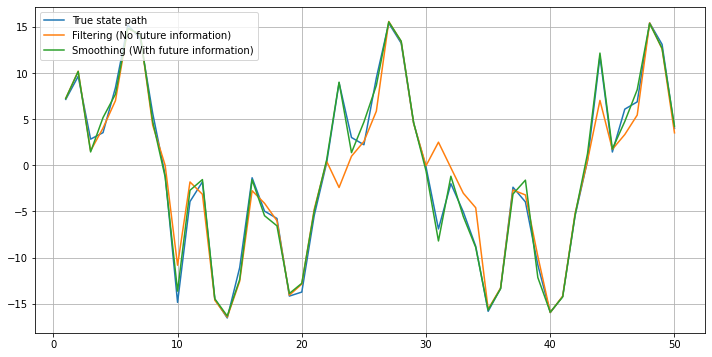

In [218]:
# Plot the result
trueX = raw_data.loc[0,:]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(1,51),trueX[1:51], label = 'True state path')
ax.plot(np.arange(1,51),EstimationResult[0][1:51], label = 'Filtering (No future information)')
ax.plot(np.arange(1,51),EstimationResult[3][1:51], label = 'Smoothing (With future information)')
ax.set_xlabel = 'time'
ax.set_ylabel = 'x_value'
ax.grid()
ax.legend()

### b)

In [219]:
# First generate all smoothing/filtering path as needed
periods = 4
nSample = 1000
t_max = 50
estimation_with_resampling = {}
estimation_without_resampling = {}
t0 = time.time()
for i in range(100):
    estimation_with_resampling[i]    = ParticleFilter(yGeneratorMaker(i), SamplingX ,CalculatingW, nSample, with_resampling = True,  smoothing_period = periods)
    estimation_without_resampling[i] = ParticleFilter(yGeneratorMaker(i), SamplingX ,CalculatingW, nSample, with_resampling = False, smoothing_period = periods)
print('The time to finish estimations is %f seconds' %(time.time() - t0))

# define a convenient function to retreve x
def access_x(i):
    return raw_data.loc[2*i,:]

# Next we conduct the calculation
RMSE = {}
for delta in range(periods+1):
    SSE = 0
    for l in range(100):
        for t in range(1,t_max+1):
            SSE += (estimation_with_resampling[l][delta][t] - access_x(l)[t])**2
    thisRMSE = np.sqrt(1/(t_max*100)*SSE)
    RMSE[('delta = %d' %delta, 'withResampling')] = thisRMSE
for delta in range(periods+1):
    SSE = 0
    for l in range(100):
        for t in range(1,t_max+1):
            SSE += (estimation_without_resampling[l][delta][t] - access_x(l)[t])**2
    thisRMSE = np.sqrt(1/(t_max*100)*SSE)
    RMSE[('delta = %d' %delta, 'withoutResampling')] = thisRMSE
print(RMSE)

The time to finish estimations is 156.279389 seconds
{('delta = 0', 'withResampling'): 3.026294034278488, ('delta = 1', 'withResampling'): 1.0164300387922125, ('delta = 2', 'withResampling'): 0.810529901149688, ('delta = 3', 'withResampling'): 0.801744818103801, ('delta = 4', 'withResampling'): 0.8034950097696019, ('delta = 0', 'withoutResampling'): 4.783510666144447, ('delta = 1', 'withoutResampling'): 2.6913880523441662, ('delta = 2', 'withoutResampling'): 2.09360279425906, ('delta = 3', 'withoutResampling'): 2.1214654977824794, ('delta = 4', 'withoutResampling'): 2.18688686743735}


In [220]:
RMSE

{('delta = 0', 'withResampling'): 3.026294034278488,
 ('delta = 1', 'withResampling'): 1.0164300387922125,
 ('delta = 2', 'withResampling'): 0.810529901149688,
 ('delta = 3', 'withResampling'): 0.801744818103801,
 ('delta = 4', 'withResampling'): 0.8034950097696019,
 ('delta = 0', 'withoutResampling'): 4.783510666144447,
 ('delta = 1', 'withoutResampling'): 2.6913880523441662,
 ('delta = 2', 'withoutResampling'): 2.09360279425906,
 ('delta = 3', 'withoutResampling'): 2.1214654977824794,
 ('delta = 4', 'withoutResampling'): 2.18688686743735}